In [1]:
from sklearnex import patch_sklearn
patch_sklearn()

import re
import sys
import os

sys.path.append(os.path.abspath(os.path.join("..")))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from pymystem3 import Mystem
from nltk.corpus import stopwords
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from gensim.models import Word2Vec
import gensim.downloader as api
from pymorphy3 import MorphAnalyzer
from joblib import Parallel, delayed

from utils import calc_metrics

import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 41825352

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [ ]:
X = pd.read_csv('../data/x.csv', index_col='date')
y = pd.read_csv('../data/y.csv', index_col='date').iloc[:, 0]

metrics = pd.read_csv('metrics.csv', index_col=0)

### Word2Vec плюс линейная модель

Обучим `Word2Vec` на текстах наших данных, а представлением текста релиза будем считать сумму, представлений всех его слов.

In [6]:
mystem = Mystem()
STOP_WORDS = set(stopwords.words('russian'))

def preprocessor(text):
    text = text.lower()
    regex = re.compile('[^а-я А-ЯЁё]')
    text = regex.sub(' ', text)
    text = ' '.join(mystem.lemmatize(text))
    text = ' '.join([word for word in text.split() if word not in STOP_WORDS])
    return text

In [14]:
def _calc_metrics(texts, window):
    model = Word2Vec(
        sentences=texts, 
        window=window,
        min_count=10, 
        vector_size=92,
        sg=1,
        epochs=100
        )

    embedings = texts.map(lambda x: [model.wv[word] for word in x if word in model.wv])
    embedings = embedings.map(lambda x: np.array(x).sum(0))
    embedings_w2v = np.array([arr.tolist() for arr in embedings])

    roc_auc, best_model = calc_metrics(
        embedings_w2v, y,
        LogisticRegression,
        name='embedings_w2v', 
        plot=False, 
        solver='saga', 
        penalty='elasticnet', 
        max_iter=10000, 
        l1_ratio=0.5
    )

    return {'window': window, 'roc_auc': roc_auc, 'model': best_model}
    
texts = X.release.map(preprocessor).str.split()

best_models = {'window': [], 'roc_auc': [], 'model': []}

results = Parallel(n_jobs=-1)(delayed(
    _calc_metrics
)(texts, window) for window in range(3, 20, 2))

best_models = {k: [dic[k] for dic in results] for k in results[0]}


Посмотрим как меняется качество модели при изменении размера окна.

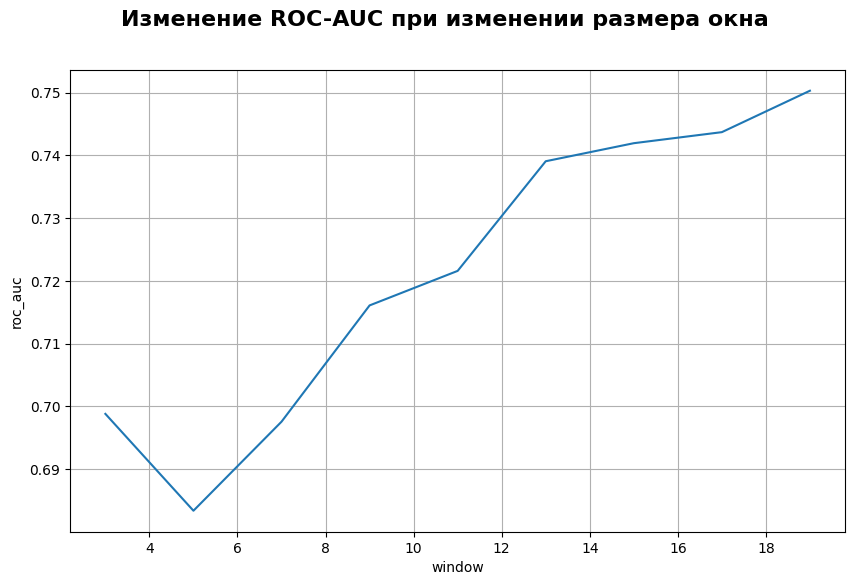

In [15]:
plt.figure(figsize=(10, 6))
data = pd.DataFrame(best_models)
sns.lineplot(x='window', y='roc_auc', data=data)
plt.suptitle("Изменение ROC-AUC при изменении размера окна", weight='bold', fontsize=16)
plt.grid()
plt.show()

При увеличении размера окна качество растет. Обучим Word2vec c размером окна 19 подберем оптимальные параметры логистической регрессии и оценим качество модели.

In [ ]:
w2v = Word2Vec(
        sentences=texts, 
        window=19,
        min_count=10, 
        vector_size=92,
        sg=1,
        epochs=100
        )

embedings = texts.map(lambda x: [w2v.wv[word] for word in x if word in w2v.wv])
embedings = embedings.map(lambda x: np.array(x).sum(0))
embedings_w2v = np.array([arr.tolist() for arr in embedings])

auc = Parallel(n_jobs=-1)(delayed(calc_metrics)(
    embedings_w2v, y,
    LogisticRegression,
    name='tf-idf', 
    plot=False, 
    solver='saga', 
    penalty='elasticnet', 
    C=c, 
    max_iter=10000, 
    l1_ratio=l1_ratio
) for c in np.linspace(0.1, 30, 10) for l1_ratio in np.logspace(-3, 0, 6))
    
roc_auc, best_model = max(auc, key=lambda x: x[0])

print(f"Лучшая модель - {best_model}")
print(f"ROC-AUC = {roc_auc}")

Лучшая модель - LogisticRegression(C=10.066666666666665, l1_ratio=1.0, max_iter=10000,
                   penalty='elasticnet', solver='saga')
ROC-AUC = 0.7533884879422637


Посмотрим на метрики модели подробнее

              precision    recall  f1-score   support

        -1.0       0.71      0.74      0.72        23
         0.0       0.46      0.42      0.44        26
         1.0       0.55      0.58      0.56        19

    accuracy                           0.57        68
   macro avg       0.57      0.58      0.58        68
weighted avg       0.57      0.57      0.57        68



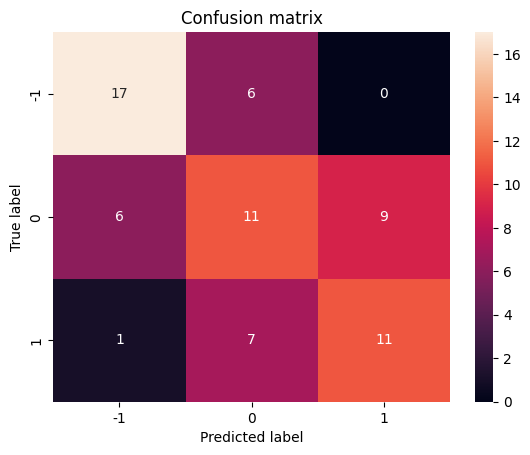

,accuracy,f1,precision,recall,roc_auc_ovr,roc_auc_ovo
min_baseline,0.659794,0.664127,0.664127,0.664127,0.742845,0.748095
bow l1 only release,0.632353,0.639291,0.645750,0.634718,0.755293,0.761178
bow elasticnet,0.676471,0.682804,0.696465,0.674852,0.837479,0.840521
bow release title,0.661765,0.666369,0.684816,0.657308,0.834681,0.837807
bow release all num,0.676471,0.681421,0.690476,0.676524,0.833032,0.836091
bow svc only release,0.632353,0.635330,0.639098,0.633046,0.773909,0.777299
tf_idf l1 only release,0.632353,0.633909,0.639423,0.633339,0.779854,0.785322
tf_idf only release best word,0.764706,0.769046,0.770299,0.770962,0.906871,0.909142
tf_idf title release,0.735294,0.740476,0.754672,0.732529,0.895373,0.898903
tf_idf numerical release,0.691176,0.694553,0.713392,0.686000,0.833339,0.835035


In [18]:
metric, model = calc_metrics(embedings_w2v, y, LogisticRegression, name='word2vec', **best_model.get_params())
metrics = pd.concat([metrics, metric], axis=0)
metrics

Качество получили хуже чем минимальный бейзлайн, потому что `word2vec` неплохо создает представления слов, но в сумме этих представлений плохо сохраняется смысл всего текста. Попробуем уже обученную модель `word2vec`. Скачаем `word2vec-ruscorpora-300` обученную на русских текстах.

In [19]:
w2v_ruscorpora = api.load('word2vec-ruscorpora-300')

# функция для добавления части речи к словам
def tag(words):
    morph = MorphAnalyzer()
    parts = [str(morph.parse(word)[0].tag.POS) for word in words]
    return [word + '_' + part for word, part in zip(words, parts)]

[==================================================] 100.0% 198.8/198.8MB downloaded


In [20]:
embedings_ruscorpora = texts.map(tag).map(lambda x: [w2v_ruscorpora[word] for word in x if word in w2v_ruscorpora])
embedings_ruscorpora = embedings_ruscorpora.map(lambda x: np.array(x).sum(0))
embedings_ruscorpora = np.array([arr.tolist() for arr in embedings_ruscorpora])

In [ ]:
auc = Parallel(n_jobs=-1)(delayed(calc_metrics)(
    embedings_ruscorpora, y,
    LogisticRegression,
    name='pretrained_word2vec', 
    plot=False, 
    solver='saga', 
    penalty='elasticnet', 
    C=c, 
    max_iter=10000, 
    l1_ratio=l1_ratio
) for c in np.linspace(0.1, 30, 10) for l1_ratio in np.logspace(-3, 0, 6))

roc_auc, best_model = max(auc, key=lambda x: x[0])

print(f"Лучшая модель - {best_model}")
print(f"ROC-AUC = {roc_auc}")

Лучшая модель - LogisticRegression(C=0.1, l1_ratio=0.0630957344480193, max_iter=10000,
                   penalty='elasticnet', solver='saga')
ROC-AUC = 0.7598867570263451


Оценим качество модели подробнее.

              precision    recall  f1-score   support

        -1.0       0.64      0.61      0.62        23
         0.0       0.47      0.54      0.50        26
         1.0       0.75      0.63      0.69        19

    accuracy                           0.59        68
   macro avg       0.62      0.59      0.60        68
weighted avg       0.60      0.59      0.59        68



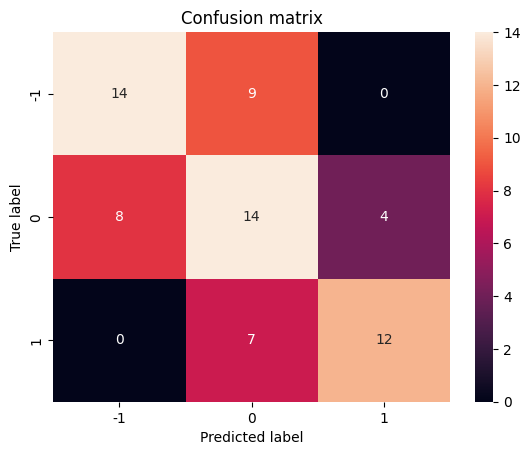

,accuracy,f1,precision,recall,roc_auc_ovr,roc_auc_ovo
min_baseline,0.659794,0.664127,0.664127,0.664127,0.742845,0.748095
bow l1 only release,0.632353,0.639291,0.645750,0.634718,0.755293,0.761178
bow elasticnet,0.676471,0.682804,0.696465,0.674852,0.837479,0.840521
bow release title,0.661765,0.666369,0.684816,0.657308,0.834681,0.837807
bow release all num,0.676471,0.681421,0.690476,0.676524,0.833032,0.836091
bow svc only release,0.632353,0.635330,0.639098,0.633046,0.773909,0.777299
tf_idf l1 only release,0.632353,0.633909,0.639423,0.633339,0.779854,0.785322
tf_idf only release best word,0.764706,0.769046,0.770299,0.770962,0.906871,0.909142
tf_idf title release,0.735294,0.740476,0.754672,0.732529,0.895373,0.898903
tf_idf numerical release,0.691176,0.694553,0.713392,0.686000,0.833339,0.835035


In [22]:
metric, model = calc_metrics(embedings_ruscorpora, y, LogisticRegression, name='word2vec_pretrained', **best_model.get_params())
metrics = pd.concat([metrics, metric], axis=0)
metrics

Качество стало немного лучше, но все равно далеко от идеала. Попробуем считать сумму ембедингов без слов, которые мы считали стоп словами в модели tf-idf.

In [23]:
with open('stopwords.txt', 'rt', encoding='utf-8') as file:
    STOP_WORDS |= set(s.strip() for s in file.readlines())

def tag(words):
    morph = MorphAnalyzer()
    parts = [str(morph.parse(word)[0].tag.POS) for word in words if word not in STOP_WORDS]
    return [word + '_' + part for word, part in zip(words, parts)]

In [24]:
embedings_ruscorpora_stop_words = texts.map(tag).map(lambda x: [w2v_ruscorpora[word] for word in x if word in w2v_ruscorpora])
embedings_ruscorpora_stop_words = embedings_ruscorpora_stop_words .map(lambda x: np.array(x).sum(0))
embedings_ruscorpora_stop_words  = np.array([arr.tolist() for arr in embedings_ruscorpora_stop_words])

In [ ]:
auc = Parallel(n_jobs=-1)(delayed(calc_metrics)(
    embedings_ruscorpora_stop_words, y,
    LogisticRegression,
    name='pretrained_word2vec', 
    plot=False, 
    solver='saga', 
    penalty='elasticnet', 
    C=c, 
    max_iter=10000, 
    l1_ratio=l1_ratio
) for c in np.linspace(0.1, 30, 10) for l1_ratio in np.logspace(-3, 0, 6))
    
roc_auc, best_model = max(auc, key=lambda x: x[0])

print(f"Лучшая модель - {best_model}")
print(f"ROC-AUC = {roc_auc}")

Лучшая модель - LogisticRegression(C=26.677777777777777, l1_ratio=1.0, max_iter=10000,
                   penalty='elasticnet', solver='saga')
ROC-AUC = 0.7178313677169513


              precision    recall  f1-score   support

        -1.0       0.44      0.48      0.46        23
         0.0       0.45      0.50      0.47        26
         1.0       0.86      0.63      0.73        19

    accuracy                           0.53        68
   macro avg       0.58      0.54      0.55        68
weighted avg       0.56      0.53      0.54        68



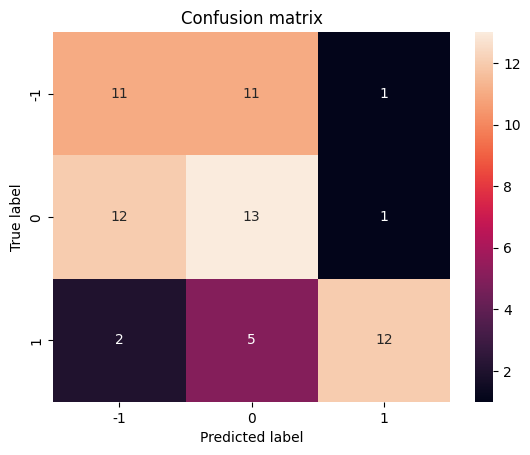

,accuracy,f1,precision,recall,roc_auc_ovr,roc_auc_ovo
min_baseline,0.659794,0.664127,0.664127,0.664127,0.742845,0.748095
bow l1 only release,0.632353,0.639291,0.645750,0.634718,0.755293,0.761178
bow elasticnet,0.676471,0.682804,0.696465,0.674852,0.837479,0.840521
bow release title,0.661765,0.666369,0.684816,0.657308,0.834681,0.837807
bow release all num,0.676471,0.681421,0.690476,0.676524,0.833032,0.836091
bow svc only release,0.632353,0.635330,0.639098,0.633046,0.773909,0.777299
tf_idf l1 only release,0.632353,0.633909,0.639423,0.633339,0.779854,0.785322
tf_idf only release best word,0.764706,0.769046,0.770299,0.770962,0.906871,0.909142
tf_idf title release,0.735294,0.740476,0.754672,0.732529,0.895373,0.898903
tf_idf numerical release,0.691176,0.694553,0.713392,0.686000,0.833339,0.835035


In [27]:
metric, model = calc_metrics(embedings_ruscorpora_stop_words, y, LogisticRegression, name='word2vec_pretrained_stop_words', **best_model.get_params())
metrics = pd.concat([metrics, metric], axis=0)
metrics

Качество сильно хуже даже минимального бейзлайна. Попробуем обучить на word2vec_pretrained SVC.

In [ ]:
auc = Parallel(n_jobs=-1)(delayed(calc_metrics)(
    embedings_ruscorpora, y,
    SVC,
    name='bow svc only release', 
    kernel=kernel,
    C=c,
    plot=False, 
    probability=True,
) for c in [0.01, 0.05, 0.1, 0.5, 1, 3, 5, 7, 10] for kernel in ['linear', 'poly', 'rbf', 'sigmoid'])

roc_auc, best_model = max(auc, key=lambda x: x[0])

print(f"Лучшая модель - {best_model}")
print(f"ROC-AUC = {roc_auc}")

Лучшая модель - SVC(C=7, kernel='linear', probability=True)
ROC-AUC = 0.7222026638502611


              precision    recall  f1-score   support

        -1.0       0.58      0.61      0.60        23
         0.0       0.42      0.38      0.40        26
         1.0       0.65      0.68      0.67        19

    accuracy                           0.54        68
   macro avg       0.55      0.56      0.55        68
weighted avg       0.54      0.54      0.54        68



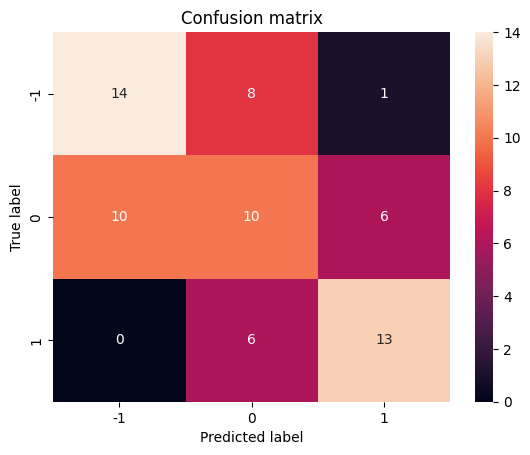

,accuracy,f1,precision,recall,roc_auc_ovr,roc_auc_ovo
min_baseline,0.659794,0.664127,0.664127,0.664127,0.742845,0.748095
bow l1 only release,0.632353,0.639291,0.645750,0.634718,0.755293,0.761178
bow elasticnet,0.676471,0.682804,0.696465,0.674852,0.837479,0.840521
bow release title,0.661765,0.666369,0.684816,0.657308,0.834681,0.837807
bow release all num,0.676471,0.681421,0.690476,0.676524,0.833032,0.836091
bow svc only release,0.632353,0.635330,0.639098,0.633046,0.773909,0.777299
tf_idf l1 only release,0.632353,0.633909,0.639423,0.633339,0.779854,0.785322
tf_idf only release best word,0.764706,0.769046,0.770299,0.770962,0.906871,0.909142
tf_idf title release,0.735294,0.740476,0.754672,0.732529,0.895373,0.898903
tf_idf numerical release,0.691176,0.694553,0.713392,0.686000,0.833339,0.835035


In [29]:
metric, _ = calc_metrics(
    embedings_ruscorpora, y, 
    SVC, 
    name='word2vec_pretrained svc', 
    **best_model.get_params()
    )

metrics = pd.concat([metrics, metric])
metrics

Качество получилось хуже чем линейная регрессия. Сохраним результаты экпериментов.

In [30]:
metrics.to_csv('metrics.csv')